<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/kapitza-pendulum-EarthPurse/blob/main/kapitza_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

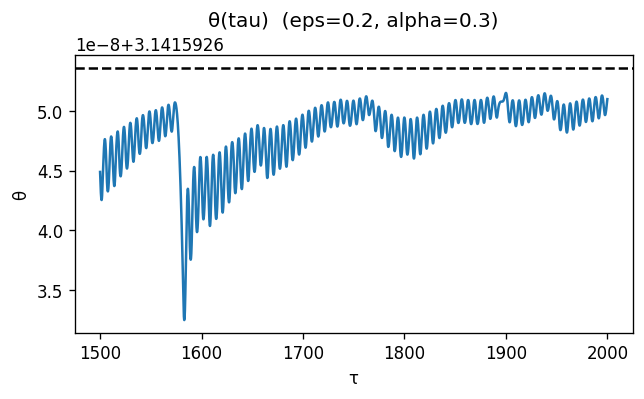

Stable? True


In [ ]:

# KAPITZA PENDULUM HW

# Import parameters
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Steps
# 1. Define equation of motion from notes:
#       θ'' = -2ζθ' – (ε² – α cos τ) sin θ
#
# 2. Integrate from τ = 0 → τ = τ_max using solve_ivp
#
# 3. Throw away early-time transient
#
# 4. Compute long-time behavior:
#       measure = max(|θ(τ) – π|)
#       state is STABLE if measure < threshold
#
# 5. Sweep over (ε, α) and store stability map.


# Equation of motion
def kapitza_eom(tau, y, epsilon, alpha, zeta):
    theta, theta_dot = y
    dtheta_dtau = theta_dot
    dtheta2_dtau2 = -2*zeta*theta_dot - (epsilon**2 - alpha*np.cos(tau)) * np.sin(theta)
    return [dtheta_dtau, dtheta2_dtau2]

# SINGLE-RUN SIMULATION
def run_sim(epsilon, alpha, zeta=0.1, tau_max=2000, transient=1500):
    """
    Returns long-time theta(tau) for the given parameters.
    Initial condition: small deviation from inverted θ = π
    """
    theta0 = np.pi - 0.01
    theta_dot0 = 0.0
    y0 = [theta0, theta_dot0]

    sol = solve_ivp(
        kapitza_eom,
        [0, tau_max],
        y0,
        args=(epsilon, alpha, zeta),
        method="Radau",
        dense_output=True,
        rtol=1e-8,
        atol=1e-8
    )

    # Sample solution
    tau = np.linspace(transient, tau_max, 5000)
    theta = sol.sol(tau)[0]

    return tau, theta

# stability diagnostic
def is_stable(theta, threshold=0.2):
    """
    Stable if θ stays near π.
    """
    dev = np.max(np.abs(theta - np.pi))
    return dev < threshold

# Plot
epsilon_test = 0.2
alpha_test = 0.3

tau, theta = run_sim(epsilon_test, alpha_test)

plt.figure(figsize=(6,3))
plt.plot(tau, theta)
plt.axhline(np.pi, color='k', ls='--')
plt.title(f"θ(tau)  (eps={epsilon_test}, alpha={alpha_test})")
plt.xlabel("τ")
plt.ylabel("θ")
plt.show()

print("Stable?" , is_stable(theta))

# parameter (ε on x-axis, α on y-axis)
eps_vals  = np.linspace(0.05, 1.0, 40)
alpha_vals = np.linspace(0.05, 1.0, 40)

stability_map = np.zeros((len(alpha_vals), len(eps_vals)))

for i, alpha in enumerate(alpha_vals):
    for j, eps in enumerate(eps_vals):
        tau, theta = run_sim(eps, alpha)
        stability_map[i, j] = 1 if is_stable(theta) else 0
        print(f"ε={eps:.3f}, α={alpha:.3f}, stable={stability_map[i,j]}", end="\r")

# 2D STABILITY PLOT
plt.figure(figsize=(6,5))
plt.imshow(
    stability_map,
    extent=[eps_vals[0], eps_vals[-1], alpha_vals[0], alpha_vals[-1]],
    aspect='auto',
    origin='lower',
    cmap='coolwarm'
)
plt.xlabel("ε (frequency ratio)")
plt.ylabel("α (drive amplitude)")
plt.title("Stability of Inverted Pendulum (1 = stable)")
plt.colorbar()
plt.show()

# Guessed boundary curve
# Simple guess: α_c = C * ε^2
C_guess = 1.2

eps_line = np.linspace(0, 1.0, 200)
alpha_line = C_guess * eps_line**2

plt.figure(figsize=(6,5))
plt.imshow(
    stability_map,
    extent=[eps_vals[0], eps_vals[-1], alpha_vals[0], alpha_vals[-1]],
    aspect='auto',
    origin='lower',
    cmap='coolwarm'
)
plt.plot(eps_line, alpha_line, 'k', lw=2, label="α_c = C ε² (guess)")
plt.xlabel("ε")
plt.ylabel("α")
plt.legend()
plt.title("Stability Map with Guessed Boundary Curve")
plt.show()

# The Kapitza pendulum is considered stable after an intial transient period. T
# The angle stays close to the inverted equillibirum.
# The pendulum will settle into either a bounded oscillation or a diverging motion.
# αc​(ϵ)=Cϵ2 was chosen for boundary since the stabalizing term is proportional to the square of the drive frequency


